In [1]:
%pylab inline 

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
from jax_nf.real_nvp import RealNVP

In [24]:
from flax import nn
import jax
import jax.numpy as np
import numpy as onp
import flax 

tfb = tfp.bijectors
tfd = tfp.distributions

In [9]:
@nn.module
def NeuralSplineCoupling(x, nunits, nbins=32):

  def bin_positions(x):
    x = np.reshape(x, [-1, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [10]:
# Instantiate the splines
d = 2
dummy_input = np.zeros((1, d//2))
_, params1 = NeuralSplineCoupling.init(jax.random.PRNGKey(0), dummy_input, d//2)

In [11]:
from functools import partial
spline1 = partial(NeuralSplineCoupling.call, params1)

In [12]:
nvp = tfd.TransformedDistribution(
        tfd.Normal(0,1),
        bijector=RealNVP(1, bijector_fn=spline1),
        event_shape=(2,))

In [13]:
samps = nvp.sample((1000,), seed=jax.random.PRNGKey(1))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


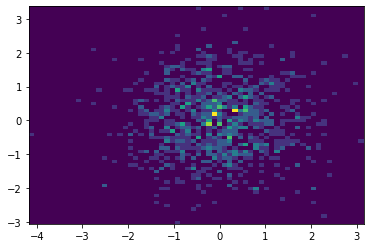

In [14]:
hist2d(samps[:,0], samps[:,1],64);

In [15]:
# Sweet :-D Hurray for TFP

In [16]:
# Let's try to learn a density

In [18]:
d=2
@nn.module
def NeuralSplineFlow(x):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    spline3 = NeuralSplineCoupling.shared(name='spline3')
    spline4 = NeuralSplineCoupling.shared(name='spline4')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline3),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=spline4)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [19]:
dummy_input = np.zeros((1,d))
res, params = NeuralSplineFlow.init(jax.random.PRNGKey(0), dummy_input)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [20]:
model = nn.Model(NeuralSplineFlow, params)

In [21]:
# Ok, sweet
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        log_prob = model(batch['x'])
        return -np.mean(log_prob)
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

In [22]:
# Now let's draw ou famous two moons
from sklearn import datasets

batch_size=256
def get_batch():
    x, y = datasets.make_moons(n_samples=batch_size, noise=.05)
    return {'x': x}

In [25]:
# okokokok, let's try it out
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
losses = []

In [ ]:
for i in range(100):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    losses.append(l)
    if  i %10 ==0:
        print(l)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


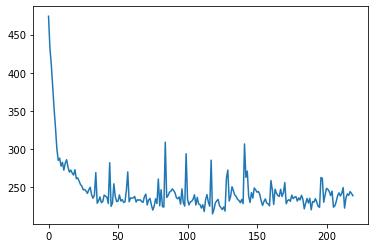

In [230]:
plot(losses)

In [231]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def NeuralSplineFlowSampler(key, n_samples):
    
    spline1 = NeuralSpline.shared(name='spline1')
    spline2 = NeuralSpline.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(onp.arange(d)[::1]),
        RealNVP(d//2, bijector_fn=spline2)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.sample(n_samples, seed=key)

In [232]:
sampler = nn.Model(NeuralSplineFlowSampler, optimizer.target.params)

In [233]:
samps = sampler(jax.random.PRNGKey(1),1000)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


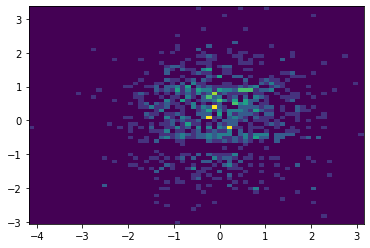

In [234]:
hist2d(samps[:,0], samps[:,1],64);

In [83]:
def loss(x):
    return -np.mean(nvp.log_prob(x))

In [86]:
model = nn.Model(NeuralSpline, params1)

In [117]:
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=RealNVP(1, bijector_fn=model),
                event_shape=(2,))
        return -np.mean(nvp.log_prob(batch['x']))
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

In [96]:
# Now let's draw ou famous two moons
from sklearn import datasets

batch_size=128
def get_batch():
    x, y = datasets.make_moons(n_samples=batch_size, noise=.05)
    return {'x': x}

In [97]:
X = get_batch()['x']

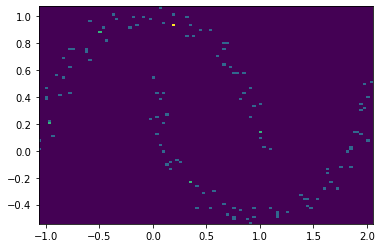

In [98]:
hist2d(X[:,0], X[:,1],100);

In [100]:
# okokokok, let's try it out
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

In [130]:
for i in range(1000):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    if  i %10 ==0:
        print(l)

126.38759
120.298325
120.98919
121.436035
119.74574
114.877106
118.36955
118.67375
117.55942
122.62619
120.019485
116.24586
117.256775
117.43939
118.84485
119.178055
124.17711
120.51706
115.818634
118.26924
117.67703
127.61462
124.993195
113.86021
123.412155
118.86015
120.3675
122.897415
125.98642
115.746574
120.83139
119.29904
118.56862
120.21105
119.4609
120.857895
115.43545
114.051315
113.54808
111.844765
119.17908
113.89007
113.21741
112.35327
112.07547
116.51413
116.97775
117.64081
116.1015
115.054855
115.09271
116.968155
120.67496
117.01786
112.311615
117.91914
113.76318
118.064995
115.67772
118.79712
112.23981
113.90381
115.8639
115.17132
114.467606
114.04404
113.731674
115.43771
111.78854
111.06248
115.639465
114.63947
118.57591
112.63108
117.314224
118.54077
118.03816
115.879364
116.48398
117.45527
110.58948
115.87412
116.44886
118.26074
113.95868
116.72723
116.019196
114.71804
116.541016
113.17034
114.57286
117.22303
116.73962
117.1223
123.04128
114.2041
117.32869
113.58739
1

In [131]:
# For testing, let's define an nvp from the current optimizer
# state

test_nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=RealNVP(1, bijector_fn=optimizer.target),
                event_shape=(2,))

In [134]:
samps = test_nvp.sample((10000,), seed=jax.random.PRNGKey(1))

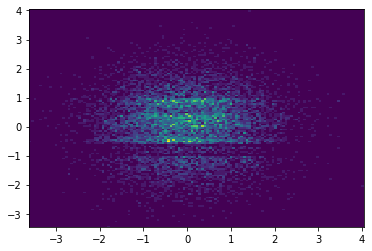

In [136]:
hist2d(samps[:,0], samps[:,1],128);